In [1]:
import numpy as np
import pylab as plt
import matplotlib
import pyLikelihood
import os
from fermipy.gtanalysis import GTAnalysis
from fermipy.plotting import ROIPlotter, SEDPlotter
from scipy.interpolate import interp1d
from scipy.integrate import quad
from scipy.optimize import brentq
from scipy.optimize import minimize_scalar
from scipy.interpolate import InterpolatedUnivariateSpline
from scipy import interpolate
from scipy.interpolate import UnivariateSpline
from fermipy import utils

In [2]:
def eflux(spectrum, emin=1e2, emax=1e5, quiet=False):
    """ Integrate a generic spectrum, multiplied by E, to get the energy flux.
    """
    espectrum = lambda e: spectrum(e)*e
    tol = min(espectrum(emin),espectrum(emax))*1e-10
    try:
        return quad(espectrum,emin,emax,epsabs=tol,full_output=True)[0]
    except (Exception, msg):
        print('Numerical error "%s" when calculating integral flux.' % msg)
        return np.nan
# Keep numpy from complaining about dN/dE = 0...
np.seterr(divide='ignore',invalid='ignore')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [3]:
# J-factor of Draco (*NO J-FACTOR UNCERTAINTY INCLUDED*)
jfactor_fermi  = 10**17.8
# Spectral file created assuming J=10^18 GeV^2/cm^5, sigmav=1e-25 cm^3/s
j0_fermi      = jfactor_fermi
sigmav0 = 1e-25
delta =2.71

In [4]:
likefile = 'likes_files/like_fornax.txt' # varialvel associada ao https://www-glast.stanford.edu/pub_data/1048/like_draco.txt
specfile = 'spectrum_bbbar_100GeV.txt' # Esse txt conseguir em um dos primeiros artigos do fermi
data = np.loadtxt(likefile, unpack=True)
emins, emaxs = np.unique(data[0]),np.unique(data[1])
ebin = np.sqrt(emins*emaxs)
efluxes = data[2].reshape(len(emins),-1)
logLikes = data[3].reshape(len(emins),-1)
Spectrum =np.loadtxt(specfile,unpack=True)
crossesctions = np.loadtxt('limits_bb.txt',unpack=True)
mass = crossesctions[0]
#crossection_fermi=crossesctions[44]


In [5]:
dlog_P8R2 = np.loadtxt('eflux_and_loglikes_files/P8R2_14Years_files/Fornax_Dloglikes_14years_P8R2.txt.txt')
eflux_P8R2 = np.loadtxt('eflux_and_loglikes_files/P8R2_14Years_files/Fornax_eflux_14years_P8R2.txt')

In [6]:
dlog_P8R3 = np.loadtxt('eflux_and_loglikes_files/P8R3_14Years_files/Fornax_Dloglikes_14years_P8R3.txt.txt')
eflux_P8R3 = np.loadtxt('eflux_and_loglikes_files/P8R3_14Years_files/Fornax_eflux_14years_P8R3.txt')

In [7]:
eflux_P8R2[0]/efluxes[0]

array([nan,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.])

## Spectrum Analyses

Fermi_spectrum_energy = np.loadtxt('1611/bin_by_bin_limits_eflux.txt')
Fermi_energy_flux = np.zeros(24)
for i in range(len(Fermi_energy_flux)):
    Fermi_energy_flux[i] = Fermi_spectrum_energy[44][i]

eflux_95_profilef = np.zeros(24)
for i in range( len(efluxes)):
    limit = utils.get_parameter_limits(efluxes[i],dlog[i])
    eflux_95_profilef[i] = limit['ul']

figure = plt.figure(figsize=(12,6))
plt.plot(ebin,Fermi_energy_flux, label = 'Fermi Result', marker ='v')
plt.plot(ebin,eflux_95_profilef, label ='Profile_norm_Function_Result', marker= '.')
#plt.plot(ebin,eflux_95_profile, label ='Profile_norm_Function_Result', marker= '.')

#plt.plot(energia,sed_draco['eflux_ul95'], label= 'SED result', marker='v')

plt.plot
plt.title('e2(dn/de) vs Energy bin')
plt.xlabel('Energy bin (Mev)')
plt.ylabel(r'$e^2(\frac{dn}{de})$')
plt.xscale('log')
plt.yscale('log')
plt.text(10e4,1e-7,'Carina', style='oblique',fontsize='15')
plt.title('eflux at 95% vs Energy bin')
plt.legend()

# Crosssection Upper Limit

In [8]:
crossection_mass_Fermi = np.zeros(len(mass))
lnl_fermi_scan_Fermi = np.zeros((len(mass),5000))
crossection_scan_Fermi= np.zeros(lnl_fermi_scan_Fermi.shape)
k =0
for i in mass:
    dmf = pyLikelihood.DMFitFunction()
    dmf.readFunction(os.path.expandvars('$FERMIPY_ROOT/data/gammamc_dif.dat'))
    dmf.setParam('norm',jfactor_fermi)
    dmf.setParam('sigmav',1E-25)
    dmf.setParam('mass',i)
    dmf.setParam('bratio',1.0)
    dmf.setParam('channel0',4)   


    energy = Spectrum[0] 
    dnde = np.zeros(energy.shape)
    for j in range(len(energy)):
        dnde[j] = dmf(pyLikelihood.dArg(energy[j]))
    
    log_energy = np.log10(energy)# Transforma energia para log
    log_dnde = np.log10(dnde)# Transforma Espectro para log
    log_interp = interp1d(log_energy,log_dnde) # Cria função de Interpolação entre energia e espectro
    spectrum = lambda e: np.nan_to_num(10**( log_interp(np.log10(e)) ))# Retorna um Valor de dn/de para um valor de energia
    
    pred = np.array([eflux(spectrum,e1,e2) for e1,e2 in zip(emins,emaxs)])  # Retorna o Eflux esperado por Bin
    likes = [ interp1d(f,l-l.max(), fill_value='extrapolate') for f,l in zip(efluxes,logLikes)] 
    like = lambda c: sum([lnlfn(c*p) for lnlfn,p in zip(likes,pred)])
    
    epsilon = 1e-4 # Just to make sure we stay within the interpolation range
    xmin =  epsilon 
    xmax = np.log10(efluxes.max()/efluxes[efluxes>0].min()) - epsilon 
    x = np.logspace(xmin,xmax,5000) 
    
    norm0 = efluxes[efluxes>0].min() / pred.max() # Cria um valor de normalização
    norms = norm0 * x # normaliza o scan range 
    
    lnl_fermi = np.array([like(n) for n in norms])
    lnl_fermi_scan_Fermi[k] =lnl_fermi
    lnl_fermi_normalizada = lnl_fermi -lnl_fermi.max()
    
    # Convert global log-likelihood back into physical units
    sigmav = j0_fermi/jfactor_fermi * sigmav0 * norms
    crossection_scan_Fermi[k] =sigmav
    mle = np.argmax(lnl_fermi_normalizada)
    lnlfn = interp1d(lnl_fermi_normalizada[mle:],sigmav[mle:])
    delta = 2.71/2
    limit = lnlfn(-delta)
    crossection_mass_Fermi[k] = float(limit)
    k= k+1  
    

In [9]:
crossection_mass_P8R2 = np.zeros(len(mass))
lnl_fermi_scan_P8R2 = np.zeros((len(mass),5000))
crossection_scan_P8R2= np.zeros(lnl_fermi_scan_P8R2.shape)
k =0
for i in mass:
    dmf = pyLikelihood.DMFitFunction()
    dmf.readFunction(os.path.expandvars('$FERMIPY_ROOT/data/gammamc_dif.dat'))
    dmf.setParam('norm',jfactor_fermi)
    dmf.setParam('sigmav',1E-25)
    dmf.setParam('mass',i)
    dmf.setParam('bratio',1.0)
    dmf.setParam('channel0',4)   


    energy = Spectrum[0] 
    dnde = np.zeros(energy.shape)
    for j in range(len(energy)):
        dnde[j] = dmf(pyLikelihood.dArg(energy[j]))
    
    log_energy = np.log10(energy)# Transforma energia para log
    log_dnde = np.log10(dnde)# Transforma Espectro para log
    log_interp = interp1d(log_energy,log_dnde) # Cria função de Interpolação entre energia e espectro
    spectrum = lambda e: np.nan_to_num(10**( log_interp(np.log10(e)) ))# Retorna um Valor de dn/de para um valor de energia
    
    pred = np.array([eflux(spectrum,e1,e2) for e1,e2 in zip(emins,emaxs)])  # Retorna o Eflux esperado por Bin
    likes = [ interp1d(f,l-l.max(), fill_value='extrapolate') for f,l in zip(eflux_P8R2,dlog_P8R2)] 
    like = lambda c: sum([lnlfn(c*p) for lnlfn,p in zip(likes,pred)])
    
    epsilon = 1e-4 # Just to make sure we stay within the interpolation range
    xmin =  epsilon 
    xmax = np.log10(efluxes.max()/efluxes[efluxes>0].min()) - epsilon 
    x = np.logspace(xmin,xmax,5000) 
    
    norm0 = efluxes[efluxes>0].min() / pred.max() # Cria um valor de normalização
    norms = norm0 * x # normaliza o scan range 
    
    lnl_fermi = np.array([like(n) for n in norms])
    lnl_fermi_scan_P8R2[k] =lnl_fermi
    lnl_fermi_normalizada = lnl_fermi -lnl_fermi.max()
    
    # Convert global log-likelihood back into physical units
    sigmav = j0_fermi/jfactor_fermi * sigmav0 * norms
    crossection_scan_P8R2[k] =sigmav
    mle = np.argmax(lnl_fermi_normalizada)
    lnlfn = interp1d(lnl_fermi_normalizada[mle:],sigmav[mle:])
    delta = 2.71/2
    limit = lnlfn(-delta)
    crossection_mass_P8R2[k] = float(limit)
    k= k+1  
    

In [10]:
crossection_mass_P8R3 = np.zeros(len(mass))
lnl_fermi_scan_P8R3 = np.zeros((len(mass),5000))
crossection_scan_P8R3= np.zeros(lnl_fermi_scan_P8R3.shape)
k =0
for i in mass:
    dmf = pyLikelihood.DMFitFunction()
    dmf.readFunction(os.path.expandvars('$FERMIPY_ROOT/data/gammamc_dif.dat'))
    dmf.setParam('norm',jfactor_fermi)
    dmf.setParam('sigmav',1E-25)
    dmf.setParam('mass',i)
    dmf.setParam('bratio',1.0)
    dmf.setParam('channel0',4)   


    energy = Spectrum[0] 
    dnde = np.zeros(energy.shape)
    for j in range(len(energy)):
        dnde[j] = dmf(pyLikelihood.dArg(energy[j]))
    
    log_energy = np.log10(energy)# Transforma energia para log
    log_dnde = np.log10(dnde)# Transforma Espectro para log
    log_interp = interp1d(log_energy,log_dnde) # Cria função de Interpolação entre energia e espectro
    spectrum = lambda e: np.nan_to_num(10**( log_interp(np.log10(e)) ))# Retorna um Valor de dn/de para um valor de energia
    
    pred = np.array([eflux(spectrum,e1,e2) for e1,e2 in zip(emins,emaxs)])  # Retorna o Eflux esperado por Bin
    likes = [ interp1d(f,l-l.max(), fill_value='extrapolate') for f,l in zip(eflux_P8R3,dlog_P8R3)] 
    like = lambda c: sum([lnlfn(c*p) for lnlfn,p in zip(likes,pred)])
    
    epsilon = 1e-4 # Just to make sure we stay within the interpolation range
    xmin =  epsilon 
    xmax = np.log10(efluxes.max()/efluxes[efluxes>0].min()) - epsilon 
    x = np.logspace(xmin,xmax,5000) 
    
    norm0 = efluxes[efluxes>0].min() / pred.max() # Cria um valor de normalização
    norms = norm0 * x # normaliza o scan range 
    
    lnl_fermi = np.array([like(n) for n in norms])
    lnl_fermi_scan_P8R3[k] =lnl_fermi
    lnl_fermi_normalizada = lnl_fermi -lnl_fermi.max()
    
    # Convert global log-likelihood back into physical units
    sigmav = j0_fermi/jfactor_fermi * sigmav0 * norms
    crossection_scan_P8R3[k] =sigmav
    mle = np.argmax(lnl_fermi_normalizada)
    lnlfn = interp1d(lnl_fermi_normalizada[mle:],sigmav[mle:])
    delta = 2.71/2
    limit = lnlfn(-delta)
    crossection_mass_P8R3[k] = float(limit)
    k= k+1  
    

In [11]:
six_years_P8R2 =  np.loadtxt('Crossections_and_loglkes_files/Upper_limits_6years_P8R2/crossection_mass_Fornax.txt')
six_years_P8R3 =  np.loadtxt('Crossections_and_loglkes_files/Upper_limits_6years_P8R3/crossection_mass_Fornax.txt')
lnl_six_years_P8R2 = np.loadtxt('Crossections_and_loglkes_files/Upper_limits_6years_P8R2/lnl_fermi_scan_Fornax.txt')
lnl_six_years_P8R3 = np.loadtxt('Crossections_and_loglkes_files/Upper_limits_6years_P8R3/lnl_fermi_scan_Fornax.txt')

In [12]:
six_years_P8R2[0]

array([6.62921587e-28, 6.64679602e-28, 6.66442280e-28, ...,
       3.70648102e-22, 3.71631031e-22, 3.72616567e-22])

In [13]:
Crossection_P8R2 = np.zeros(len(crossection_mass_P8R3))
Crossection_P8R3 = np.zeros(len(crossection_mass_P8R3))
for i in range(len(six_years_P8R2)):
  Crossection_P8R2[i] = utils.get_parameter_limits(six_years_P8R2[i],lnl_six_years_P8R2[i])['ul']
  Crossection_P8R3[i] = utils.get_parameter_limits(six_years_P8R3[i],lnl_six_years_P8R3[i])['ul']

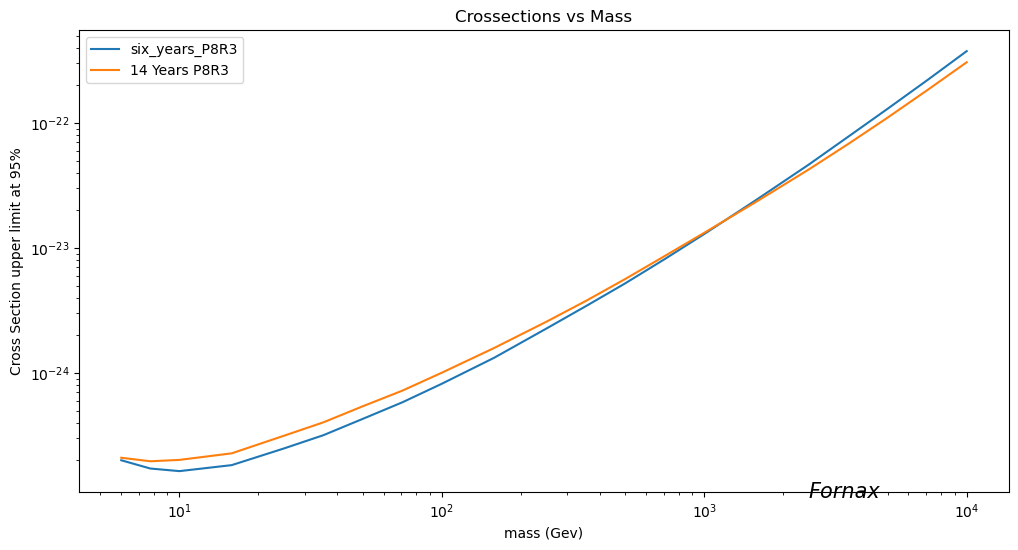

In [19]:
fig =plt.figure(figsize=(12,6))
#plt.plot(mass,crossection_mass_P8R2, label = '14 years P8R2')
#plt.plot(mass,Crossection_P8R2,label= 'six_years_P8R2')
plt.plot(mass,Crossection_P8R3, label = 'six_years_P8R3')
plt.plot(mass,crossection_mass_P8R3, label = '14 Years P8R3 ')
#plt.plot(mass,crossesctions[14], label = 'Arxiv :1611 - Fermi 2015')
#plt.plot(mass,crossection_mass_Fermi, label ='Arxiv :1611 - Fermi 2015 without J factor')
plt.xlabel('mass (Gev)')
plt.ylabel('Cross Section upper limit at 95%')
plt.title('Crossections vs Mass')
plt.xscale('log')
plt.yscale('log')
plt.text(2.5e3,1e-25,'Fornax', style='oblique',fontsize='15')
plt.legend()

In [15]:
np.savetxt('Crossections_and_loglkes_files/Upper_limits_14years_P8R2/lnl_fermi_scan_Draco.txt',lnl_fermi_scan_P8R2)
np.savetxt('Crossections_and_loglkes_files/Upper_limits_14years_P8R2/crossection_mass_Draco.txt',crossection_scan_P8R2)

In [16]:
np.savetxt('Crossections_and_loglkes_files/Upper_limits_14years_P8R3/lnl_fermi_scan_Draco.txt',lnl_fermi_scan_P8R3)
np.savetxt('Crossections_and_loglkes_files/Upper_limits_14years_P8R3/crossection_mass_Draco.txt',crossection_scan_P8R3)